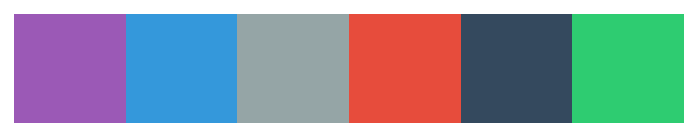

In [1]:
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use("seaborn-poster") ### Use this for figures used in posters
# plt.style.use("seaborn-paper") ### Use this for figures used in paper
# plt.style.use("seaborn-talk") ### Use this for figures used in presentations/talks
import scipy.misc
from sargan_models import SARGAN
from utils import imsave
import tensorflow as tf
import numpy as np
import time
import sys
from tqdm import tqdm
from sar_utilities import to_dB, visualize_raw_data, get_spectrum, \
    visualize_raw_data_spectrum, insert_freq_gaps, \
    generate_raw_data_from_dict, downsample, snr, \
    add_gaussian_noise, preprocess_train, preprocess_test, \
    generate_raw_data
import math
from alert_utilities import send_images_via_email
import time
import scipy.io as sio
%matplotlib inline
%config InlineBackend.figure_format = "retina"

mpl.rcParams["axes.grid"] = False
mpl.rcParams["grid.color"] = "#f5f5f5"
mpl.rcParams["axes.facecolor"] = "#ededed"
mpl.rcParams["axes.spines.left"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.bottom"] = False
mpl.rcParams['axes.labelcolor'] = "grey"
mpl.rcParams['xtick.color'] = 'grey'
mpl.rcParams['ytick.color'] = 'grey'
from cycler import cycler
import seaborn as sns
color_palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.palplot(color_palette)
mpl.rcParams["axes.prop_cycle"] = cycler('color', color_palette)

import pickle

DATA_PATH = "/data/dung/sargan"

import os
data_filename = "sar_dict_small_no_downsampling"
with open(os.path.join(DATA_PATH, data_filename + ".pickle"), 'rb') as handle:
    sar_dict_data = pickle.load(handle)
    
sar_dict_mat = sar_dict_data["sar_dict_mat"]
ori_n_samples = sar_dict_data["n_samples"]
ori_n_apertures = sar_dict_data["n_apertures"]
sampling_period = sar_dict_data["transmistted_pulse_sample_period"]
n_atoms = sar_dict_mat.shape[1]

downsample_factor = 4
DOWNSAMPLE = False
if DOWNSAMPLE:
    n_samples = math.ceil(ori_n_samples / downsample_factor)
    n_apertures = math.ceil(ori_n_apertures / downsample_factor)
else:
    n_samples = ori_n_samples
    n_apertures = ori_n_apertures
    
n_fft = ori_n_samples
sampling_freq = 1. / (sampling_period + 1e-32)
df = sampling_freq / n_fft
freq = [df*i / 1e6 for i in range(0, n_fft)]    

freq_band = (380e6, 2080e6)
freq_band_width = freq_band[1] - freq_band[0]
missing_rate = 0.8
missing_band_width = round(freq_band_width * missing_rate)
gap_width = missing_band_width
f_start = np.array([freq_band[0] + round(0.1*freq_band_width)])
f_end = f_start + gap_width
f_start_idx = np.int_(np.ceil(f_start / df))
f_end_idx = np.int_(np.ceil(f_end / df))
freq_gaps = [f_start_idx, f_end_idx]

if DOWNSAMPLE:
    from sargan_config import ConfigDownsample as conf
else:
    from sargan_config import Config as conf

from sargan_config import Config as conf
    
img_size = (n_samples, n_apertures)
train_size = img_size
batch_size = conf.batch_size
img_channel = conf.img_channel
conv_channel_base = conf.conv_channel_base

learning_rate = conf.learning_rate
beta1 = conf.beta1
max_epoch = conf.max_epoch
L1_lambda = conf.L1_lambda
save_per_epoch = conf.save_per_epoch

trained_models_path = conf.trained_models_path
data_name = 'synthetic_sar'
experiment_name = "freq_corrupted_real"
db_range = 20 # For visualizing raw dta

output_path = os.path.join(conf.output_path, experiment_name)

ori_color = color_palette[1]
corrupted_color = color_palette[0]
reconstructed_color = color_palette[5]


real_data_filename = "real_sar_data/C2.mat"
real_data_file_path = os.path.join(DATA_PATH, real_data_filename)
real_mat_data = sio.loadmat(real_data_file_path)
real_raw_data = real_mat_data["Data"]
real_ori_n_samples, real_ori_n_apertures = real_raw_data.shape
calibrated_real_raw_data = 1e4*np.vstack((np.zeros((300, real_ori_n_apertures)), real_raw_data, np.zeros((600, real_ori_n_apertures))))
calibrated_real_raw_data_batch = np.hsplit(calibrated_real_raw_data, [301, 602, 903, 1204, 1505])
calibrated_real_raw_data_batch.pop()
calibrated_real_raw_data_batch = np.asarray(calibrated_real_raw_data_batch)

In [2]:
calibrated_real_raw_data_batch.shape

(5, 1500, 301)

In [3]:
conf.batch_size

1

In [4]:
start_idx = 100
real_test_data = calibrated_real_raw_data_batch[1, :, :]

In [5]:
calibrated_real_raw_data_batch.shape

(5, 1500, 301)

/home/dung/Development/sargan_v3/sar_utilities.py:8: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(np.abs(s))


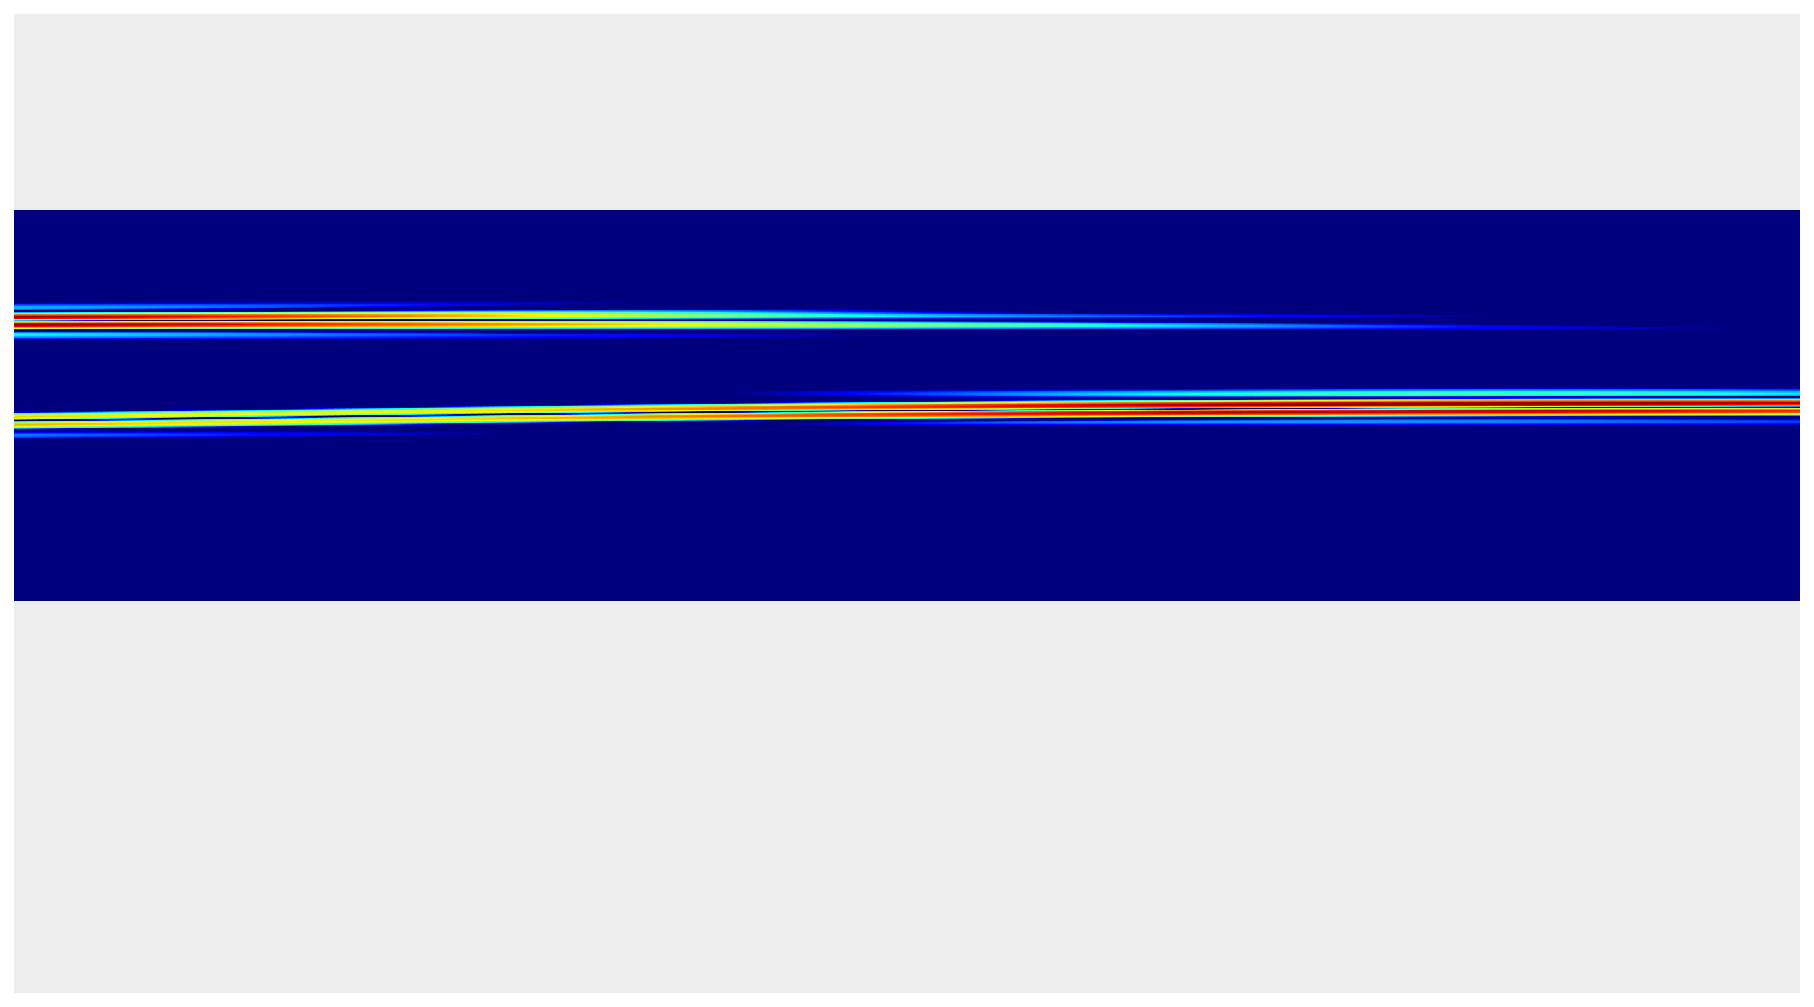

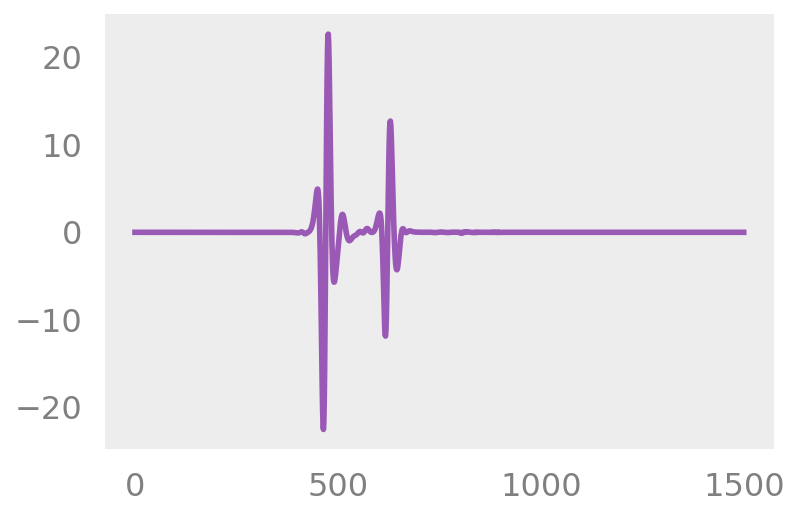

In [6]:
batch_idx = 3
fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111);
ax = visualize_raw_data(calibrated_real_raw_data_batch[batch_idx, :, :], ax)
fig = plt.figure(); 
ax = fig.add_subplot(111)
ax.plot(calibrated_real_raw_data_batch[batch_idx, :, 0])

In [7]:
model = SARGAN(img_size, batch_size)
d_opt = tf.train.AdamOptimizer(learning_rate=conf.learning_rate).minimize(model.d_loss, var_list=model.d_vars)
g_opt = tf.train.AdamOptimizer(learning_rate=conf.learning_rate).minimize(model.g_loss, var_list=model.g_vars)

saver = tf.train.Saver()

start_time = time.time()
gpu_options = tf.GPUOptions(allow_growth=True, visible_device_list='2')
config=tf.ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True

TEST_REAL_DATA = True
if TEST_REAL_DATA:
    n_test_iters = 1
else:
    n_test_iters = 2
sparsity_rate = 0.2

model_trained_epoch = 100

model_path_test = conf.trained_models_path + "/checkpoint/" + "%s_%s_model_%s.ckpt" % (data_name, experiment_name, model_trained_epoch)
epoch_snr_gain = []

with tf.Session(config=config) as sess:

    saver.restore(sess, model_path_test)
    for i_test in range(n_test_iters):
        #img = generate_raw_data_from_dict(sar_dict_mat, n_targets=n_targets, batch_size=batch_size)
        if not TEST_REAL_DATA:
            img = generate_raw_data(sar_dict_mat, sparsity_rate, batch_size, coefficient_range=(-1, 1))
        else:
            img = calibrated_real_raw_data_batch[batch_idx:batch_idx+batch_size, :, :]
        cond = img.copy()
        pcond, _ = insert_freq_gaps(cond, (ori_n_samples, ori_n_apertures), freq_gaps)
        pimg, pcond = preprocess_test(img, pcond, (ori_n_samples, ori_n_apertures), DOWNSAMPLE, downsample_factor)                    
        gen_img = sess.run(model.gen_img, feed_dict={model.image:pimg, model.cond:pcond})
        in_snr, out_snr, snr_gain = snr(pimg, pcond, gen_img, norm_flag=0, mag_flag=0)
        print(snr_gain)
        epoch_snr_gain.append(snr_gain)

Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Restoring parameters from /data/dung/sargan/trained_models/checkpoint/synthetic_sar_freq_corrupted_real_model_100.ckpt


/home/dung/Development/sargan_v3/sar_utilities.py:68: ComplexWarning: Casting complex values to real discards the imaginary part
  mask[f_start_idx[i] : f_end_idx[i], :] = 0.0 + 0.0j


0.7380278633813608


/home/dung/Development/sargan_v3/sar_utilities.py:8: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(np.abs(s))


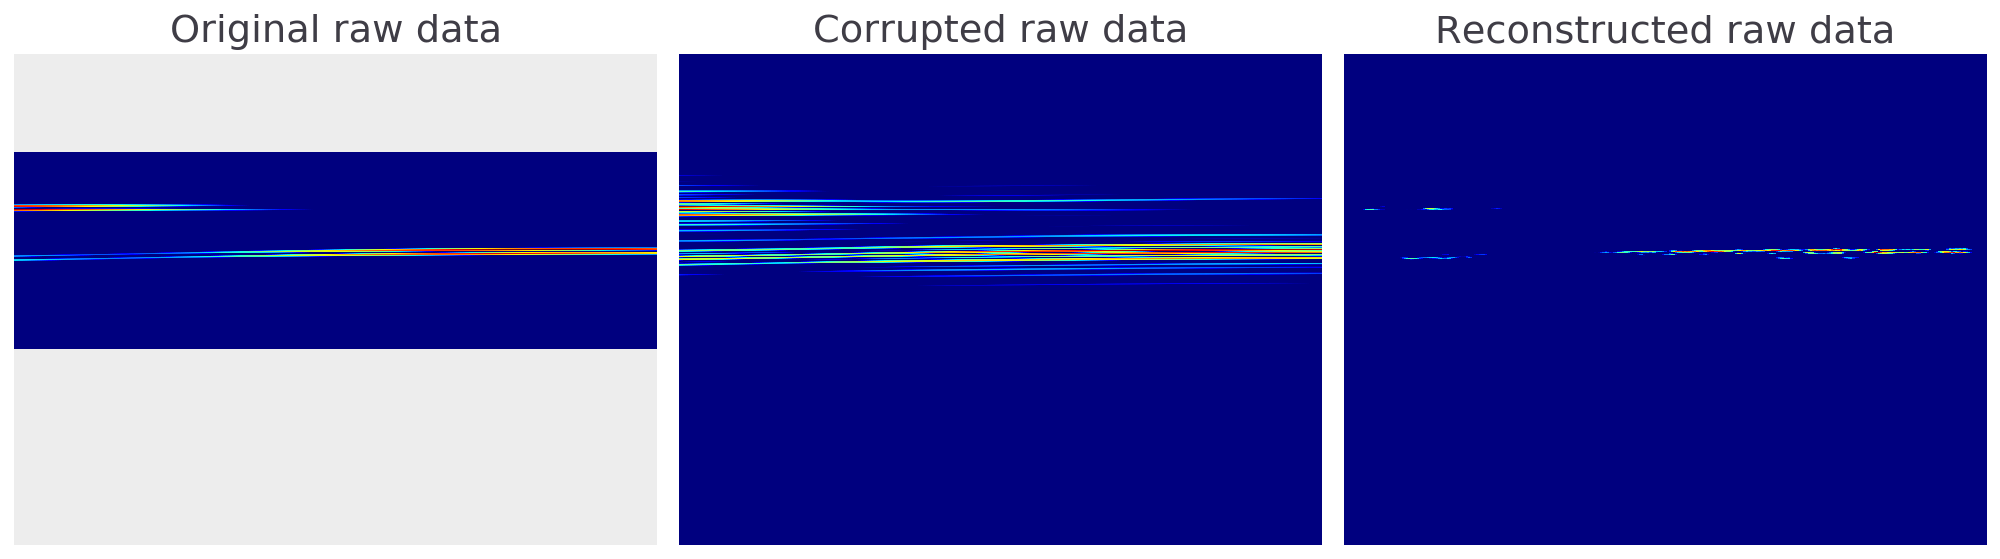

In [8]:
db_range = 9
# Time domain visualization: corrupted
fig = plt.figure(figsize=(14, 4)); 
ax = fig.add_subplot(131)
ax = visualize_raw_data(pimg[0, :, :, 0], ax, db_range)
ax.set_title("Original raw data")
ax = fig.add_subplot(132)
ax = visualize_raw_data(pcond[0, :, :, 0], ax, db_range+6)
ax.set_title("Corrupted raw data")
ax = fig.add_subplot(133)
ax = visualize_raw_data(gen_img[0, :, :, 0], ax, db_range-2)
ax.set_title("Reconstructed raw data")
plt.tight_layout()
# test_filename_raw = os.path.join(output_path, '%s_epoch_%s_raw_batchsize_%s.jpg' % (experiment_name, model_trained_epoch, batch_size))
# plt.savefig(test_filename_raw, dpi=300)

(0, 1500)

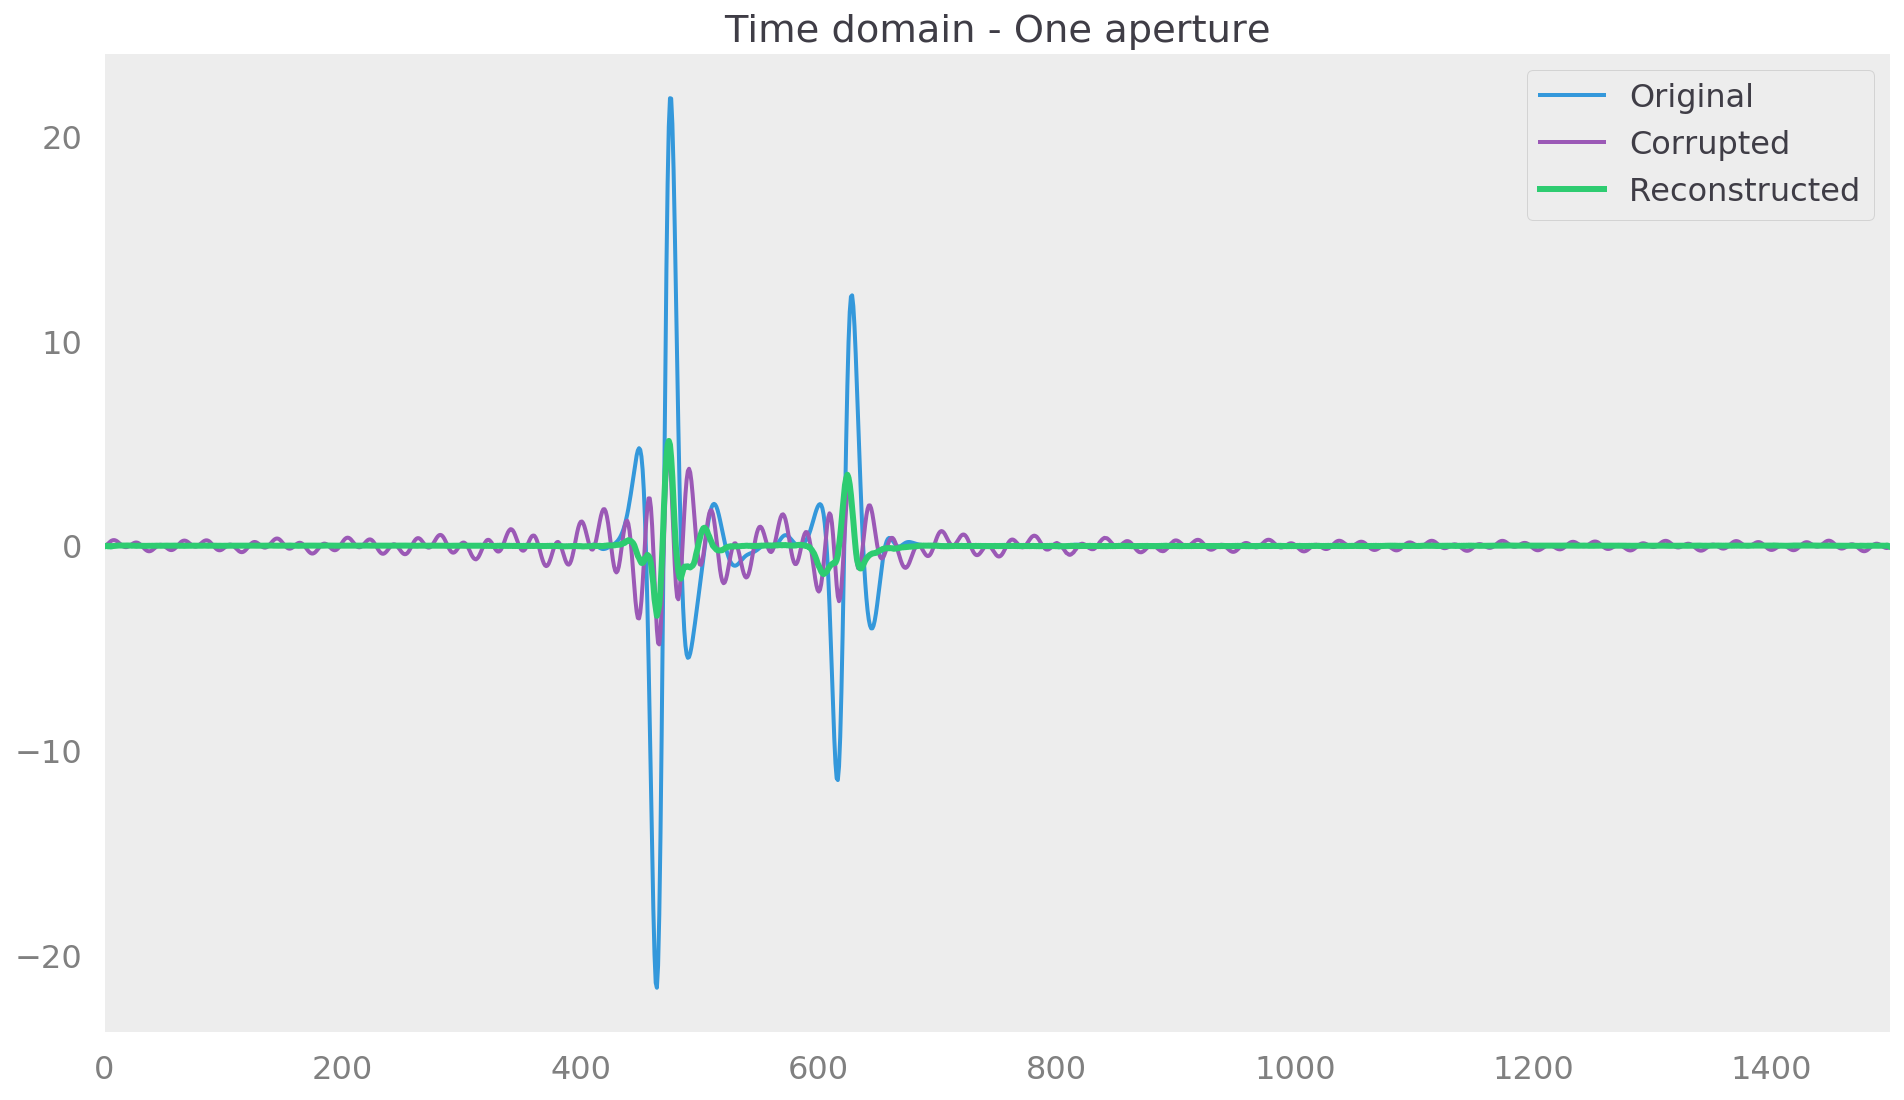

In [9]:
line_idx = 10
fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111);
ax.plot(pimg[0, :, line_idx, 0], color=ori_color, lw=2.0)
ax.plot(pcond[0, :, line_idx, 0], color=corrupted_color, lw=2.0)
ax.plot(gen_img[0, :, line_idx, 0], color=reconstructed_color, lw=3.0)
ax.set_title("Time domain - One aperture")
ax.legend(["Original", "Corrupted", "Reconstructed"])
ax.set_xlim([0, pimg[0, :, line_idx, 0].shape[0]])
# test_filename_one_aperture = os.path.join(output_path, '%s_epoch_%s_one_aperture_batchsize_%s.jpg' % (experiment_name, model_trained_epoch, batch_size))
# plt.savefig(test_filename_one_aperture, dpi=300)

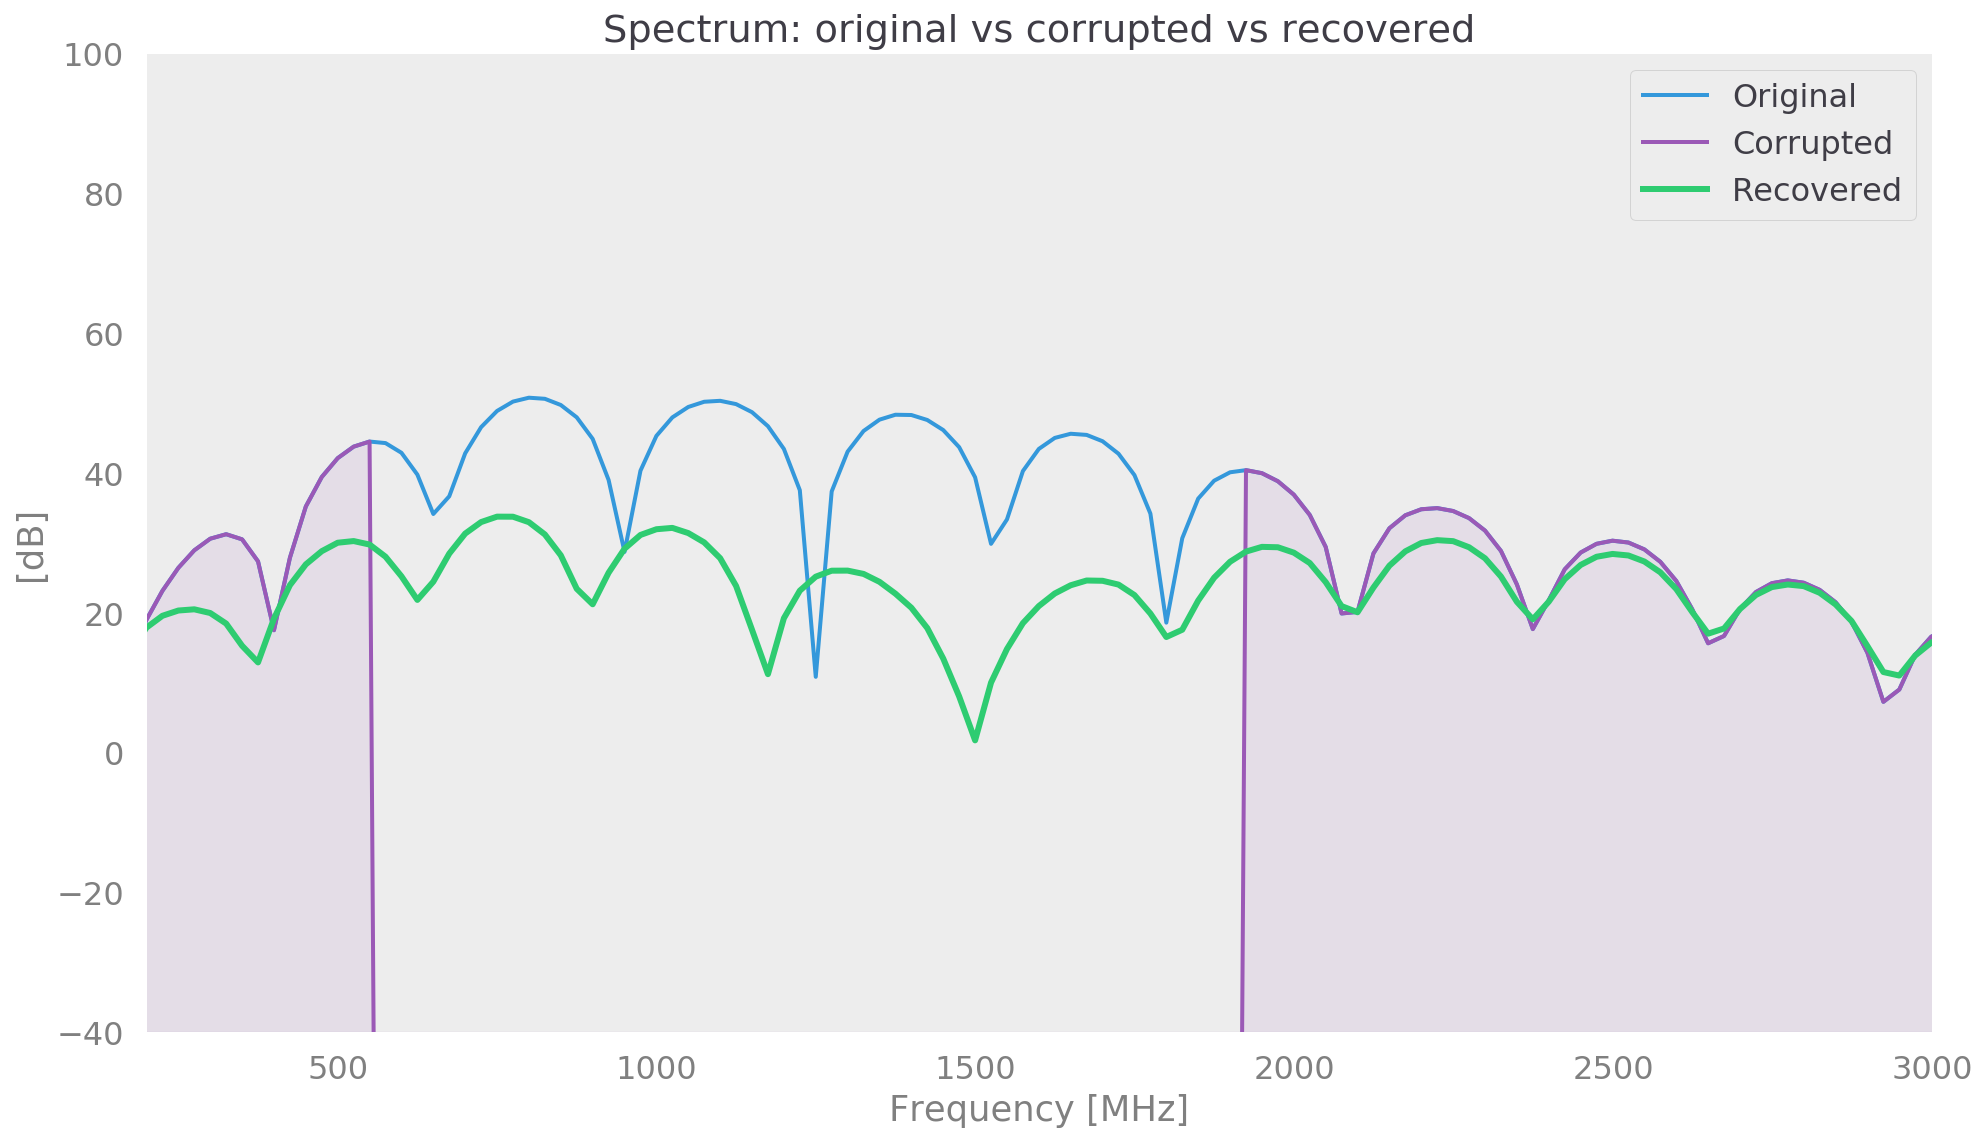

In [10]:
# Spectrum visualization: original vs corrupted vs reconstructed

n_fft = n_samples
zoom_factor = 8
fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111);
raw_spectrum = get_spectrum(pimg[0, :, :, 0], n_fft)
raw_spectrum_dB = to_dB(np.mean(raw_spectrum[0:n_fft//zoom_factor, :], axis=1))
corrupted_spectrum = get_spectrum(pcond[0, :, :, 0], n_fft)
corrupted_spectrum_dB = to_dB(np.mean(corrupted_spectrum[0:n_fft//zoom_factor, :], axis=1))
corrupted_spectrum_dB[corrupted_spectrum_dB==-np.inf] = -170
recovered_spectrum = get_spectrum(gen_img[0, :, :, 0], n_fft)
recovered_spectrum_dB = to_dB(np.mean(recovered_spectrum[0:n_fft//zoom_factor, :], axis=1))
ax.plot(freq[0:n_fft // zoom_factor], raw_spectrum_dB, color=ori_color, lw=2.0)
ax.plot(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB, color=corrupted_color, lw=2.0)
ax.plot(freq[0:n_fft // zoom_factor], recovered_spectrum_dB, color=reconstructed_color, lw=3.0)
y_min = -40
y_max = 100
ax.set_ylim([y_min, y_max]); 
ax.set_xlim([200, 3000])
ax.set_title("Spectrum: original vs corrupted vs recovered", )
ax.legend(["Original", "Corrupted", "Recovered"])
ax.set_xlabel("Frequency [MHz]"); ax.set_ylabel("[dB]")
ax.fill_between(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB, y_min, color=corrupted_color, alpha=0.1)
# test_filename_spectrum = os.path.join(output_path, '%s_epoch_%s_spectrum_batchsize_%s.jpg' % (experiment_name, model_trained_epoch, batch_size))
# plt.savefig(test_filename_spectrum, dpi=300)

In [11]:
img.shape

(1, 1500, 301)